<h1> Create Keras DNN model </h1>
AAT notes

This notebook illustrates:
<ol>
<li> Creating a model using Keras. This requires TensorFlow 2.1
</ol>
The want to run locally and these are the main steps
<ol>
<li>load data</li>
<li>make features</li>
<li>compile model</li>
<li>train model</li>
<li>Save model</li>
<li>Load a saved model</li>
<li>make predictions</li>
</ol>

## install libraries

`pip install pydot`

`pip install pydotplus`

`pip install graphviz`

in linux:

`sudo apt-get install graphviz`

in windows:

https://www2.graphviz.org/Packages/development/windows/10/cmake/Release/



In [1]:
%%cmd
pip freeze | findstr tensor

Microsoft Windows [Version 10.0.19041.685]
(c) 2020 Microsoft Corporation. All rights reserved.

C:\Users\artur\git\gcp_ml_certification>pip freeze | findstr tensor
tensorboard==2.4.0
tensorboard-plugin-wit==1.7.0
tensorflow==2.4.0
tensorflow-estimator==2.4.0

C:\Users\artur\git\gcp_ml_certification>

In [2]:
# change these to try this notebook out
BUCKET  = 'cloud-training-demos-ml'
PROJECT = 'cloud-training-demos'
REGION  = 'us-east1' #'us-central1'

In [3]:
import os
os.environ[ 'BUCKET'  ] = BUCKET
os.environ[ 'PROJECT' ] = PROJECT
os.environ[ 'REGION'  ] = REGION

%%bash
if ! gsutil ls | grep -q gs://${BUCKET}/; then
  gsutil mb -l ${REGION} gs://${BUCKET}
fi

%%bash
ls *.csv

## Create Keras model
<p>
First, write an input_fn to read the data.

In [4]:
import shutil
import numpy as np
import tensorflow as tf
print(tf.__version__)

2.4.0


In [5]:
# Determine CSV, label, and key columns
CSV_COLUMNS  = 'weight_pounds,is_male,mother_age,plurality,gestation_weeks,key'.split(',')
LABEL_COLUMN = 'weight_pounds'
KEY_COLUMN   = 'key'

# Set default values for each CSV column. Treat is_male and plurality as strings.
DEFAULTS = [[0.0], ['null'], [0.0], ['null'], [0.0], ['nokey']]

In [6]:
def features_and_labels(row_data):
    for unwanted_col in ['key']:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label  # features, label

# load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
  dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
             .map(features_and_labels) # features, label
             )
  if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
  dataset = dataset.prefetch(1) # take advantage of multi-threading; 1=AUTOTUNE
  return dataset

Next, define the feature columns. mother_age and gestation_weeks should be numeric.
The others (is_male, plurality) should be categorical.

In [7]:
## Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true))) 

# Helper function to handle categorical columns
def categorical_fc(name, values):
  return tf.feature_column.indicator_column(
    tf.feature_column.categorical_column_with_vocabulary_list(name, values))

def build_dnn_model():
    # input layer
    inputs = {
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='float32')
           for colname in ['mother_age', 'gestation_weeks']
    }
    inputs.update({
        colname : tf.keras.layers.Input(name=colname, shape=(), dtype='string')
            for colname in ['is_male', 'plurality']        
    })

    # feature columns from inputs
    feature_columns = {
        colname : tf.feature_column.numeric_column(colname)
            for colname in ['mother_age', 'gestation_weeks']
    }
    if False:
        # Until TF-serving supports 2.0, so as to get servable model
        feature_columns['is_male'] = categorical_fc('is_male', ['True', 'False', 'Unknown'])
        feature_columns['plurality'] = categorical_fc('plurality',
                          ['Single(1)', 'Twins(2)', 'Triplets(3)',
                           'Quadruplets(4)', 'Quintuplets(5)','Multiple(2+)'])

    # the constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify: LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of [64, 32] just in like the BQML DNN
    h1 = tf.keras.layers.Dense(64, activation='relu', name='h1')(dnn_inputs)
    h2 = tf.keras.layers.Dense(32, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation='linear', name='babyweight')(h2)
    

    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer='adam', loss='mse', metrics=[rmse, 'mse'])    
    return model

print("Here is our DNN architecture so far:\n")

# note how to use strategy to do distributed training
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far:

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
gestation_weeks (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
is_male (InputLayer)            [(None,)]            0                                            
__________________________________________________________________________________________________
mother_age (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
plurality (InputLayer)          [(None,)]            

We can visualize the DNN using the Keras plot_model utility.

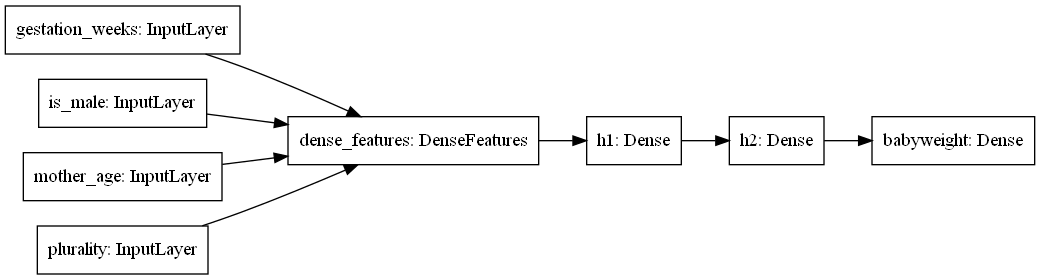

In [8]:
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

In [10]:
from graphviz import Digraph

g = Digraph()
# Add nodes 1 and 2

with g.subgraph(name='cluster_input_layer') as c:
  c.attr(style='filled', color='pink', rankdir='TB')
  c.attr(label='input layer')
  c.node_attr.update(style='filled', color='magenta')
  
  for column in CSV_COLUMNS:
    if column == "weight_pounds":
      continue
    c.node( column  )

with g.subgraph(name='cluster_dense_layer') as c:
  c.attr(style='filled', color='blue', rankdir='TB')
  c.node( 'dense_features'  ,color='cyan', style='filled', fillcolor='cyan'    )
  c.edge( 'is_male'         , 'dense_features', constraint='false')
  c.edge( 'mother_age'      , 'dense_features', constraint='false')
  c.edge( 'plurality'       , 'dense_features', constraint='false')
  c.edge( 'gestation_weeks' , 'dense_features', constraint='false')

with g.subgraph(name='cluster_hiden_1') as c:
  c.attr(style='filled', color='gold', rankdir='TB')
  c.attr(label='hiden layer 1. 64 neurons')
  c.node( 'h1'    ,color='yellow', style='filled', fillcolor='yellow'    )

with g.subgraph(name='cluster_hiden_2') as c:
  c.attr(style='filled', color='gold2', rankdir='TB')
  c.attr(label='hiden layer 2. 32 neurons')
  c.node( 'h2'    ,color='yellow', style='filled', fillcolor='yellow'    )


g.node( 'weight', color='green', style='filled', fillcolor='green'   )

g.edge( 'dense_features', 'h1'     , constraint='false' )
g.edge( 'h1'            , 'h2'     , constraint='false' )
g.edge( 'h2'            , 'weight' , constraint='false' )


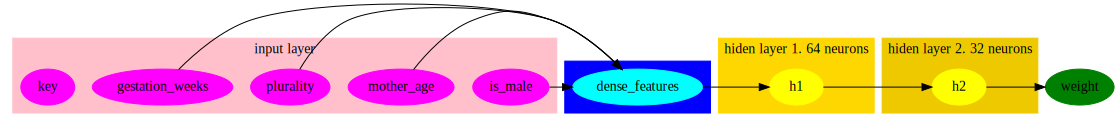

In [11]:
g

### input files

In [12]:
input_dir = 'C:/Users/artur/git/training-data-analyst/courses/machine_learning/deepdive/06_structured'
train_csv = os.path.join( input_dir, 'train.csv' )
eval_csv  = os.path.join( input_dir, 'eval.csv'  )


## Train and evaluate

In [13]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # training dataset repeats, so it will wrap around
NUM_EVALS = 5  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset( train_csv, TRAIN_BATCH_SIZE, tf.estimator.ModeKeys.TRAIN)
evalds  = load_dataset( eval_csv , 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

history = model.fit(trainds, 
                    validation_data=evalds,
                    epochs=NUM_EVALS, 
                    steps_per_epoch=steps_per_epoch)

Epoch 1/5
312/312 [==============================] - 6s 10ms/step - loss: 3.8516 - rmse: 1.6068 - mse: 3.8516 - val_loss: 1.2717 - val_rmse: 1.1273 - val_mse: 1.2717
Epoch 2/5
312/312 [==============================] - 1s 3ms/step - loss: 1.2423 - rmse: 1.1040 - mse: 1.2423 - val_loss: 1.3087 - val_rmse: 1.1438 - val_mse: 1.3087
Epoch 3/5
312/312 [==============================] - 1s 3ms/step - loss: 1.2685 - rmse: 1.1149 - mse: 1.2685 - val_loss: 1.2442 - val_rmse: 1.1151 - val_mse: 1.2442
Epoch 4/5
312/312 [==============================] - 1s 2ms/step - loss: 1.2801 - rmse: 1.1192 - mse: 1.2801 - val_loss: 1.2447 - val_rmse: 1.1155 - val_mse: 1.2447
Epoch 5/5
312/312 [==============================] - 1s 2ms/step - loss: 1.2376 - rmse: 1.1008 - mse: 1.2376 - val_loss: 1.2291 - val_rmse: 1.1083 - val_mse: 1.2291


## Visualize loss curve

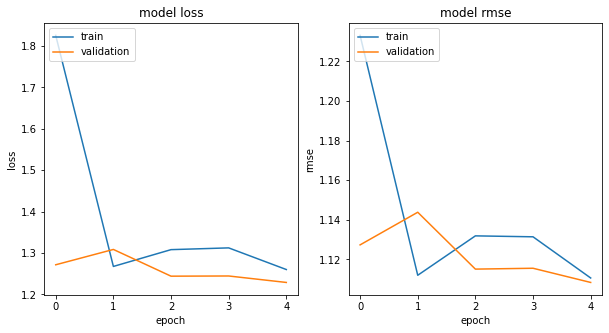

In [14]:
# plot
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
fig = plt.figure(figsize=(10, 5))

for idx, key in enumerate(['loss', 'rmse']):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    plt.plot(history.history[key])
    plt.plot(history.history['val_{}'.format(key)])
    plt.title('model {}'.format(key))
    plt.ylabel(key)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left');

## Save the model

Let's wrap the model so that we can supply keyed predictions, and get the key back in our output

In [15]:
# Serving function that passes through keys
@tf.function(input_signature=[{
      'is_male'         : tf.TensorSpec([None,], dtype=tf.string , name= 'is_male'         ),
      'mother_age'      : tf.TensorSpec([None,], dtype=tf.float32, name= 'mother_age'      ),
      'plurality'       : tf.TensorSpec([None,], dtype=tf.string , name= 'plurality'       ),
      'gestation_weeks' : tf.TensorSpec([None,], dtype=tf.float32, name= 'gestation_weeks' ),
      'key'             : tf.TensorSpec([None,], dtype=tf.string , name= 'key'             )
}])
def my_serve(inputs):
    feats = inputs.copy()
    key = feats.pop('key')
    output = model(feats)
    return {'key': key, 'babyweight': output}

### set path variables

In [32]:
import shutil, os, datetime

OUTPUT_DIR = './export/babyweight'
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR, datetime.datetime.now().strftime('%Y%m%d%H%M%S'))

EXPORT_PATH = EXPORT_PATH.replace( '\\', '/' )

signatures = { 'serving_default': my_serve }

In [33]:
print( 'OUTPUT_DIR: {}'.format( OUTPUT_DIR ) )

print( 'EXPORT_PATH: {}'.format( EXPORT_PATH ) )

OUTPUT_DIR: ./export/babyweight
EXPORT_PATH: ./export/babyweight/20201227085514


### save model to file

In [34]:
tf.saved_model.save(model, EXPORT_PATH, signatures= signatures )

#model.save( EXPORT_PATH  )

print("Exported trained model to {}".format(EXPORT_PATH))
os.environ['EXPORT_PATH'] = EXPORT_PATH

INFO:tensorflow:Assets written to: ./export/babyweight/20201227085514\assets
Exported trained model to ./export/babyweight/20201227085514


### save model as H5

In [24]:
modelh5_path = os.path.join( os.getcwd(), 'baby.h5' ).replace( '\\', '/' )

model.save( modelh5_path  )

## Load saved model

### load h5 model

In [25]:
h5_model = tf.keras.models.load_model( modelh5_path )

ValueError: Unknown metric function: rmse

In [35]:
output_path = os.path.join( os.getcwd(), 'export', 'babyweight' ).replace( '\\', '/' )
print( 'output_path: {}'.format( output_path) )

dirs = [ os.path.join(output_path, name) for name in os.listdir( output_path) if os.path.isdir(os.path.join(output_path, name)) ]
dirs = sorted( dirs )

for i in dirs:
    print( 'i: {}'.format( i ) )


output_path: C:/Users/artur/git/gcp_ml_certification/export/babyweight
i: C:/Users/artur/git/gcp_ml_certification/export/babyweight\20201227085514


In [36]:
model_path = dirs[ 0 ]
model_path = model_path.replace( '\\', '/' )
model_path

'C:/Users/artur/git/gcp_ml_certification/export/babyweight/20201227085514'

In [38]:
#my_dic = {'f1':f1}

new_model = tf.keras.models.load_model( model_path )

#new_model = tf.keras.models.load_model( model_path )


ValueError: Unable to restore custom object of type _tf_keras_metric currently. Please make sure that the layer implements `get_config`and `from_config` when saving. In addition, please use the `custom_objects` arg when calling `load_model()`.

## make predictions

### passing parameters on the fly

### passing a json file

## Deploy trained model to Cloud AI Platform


In [ ]:
!saved_model_cli show --tag_set serve --signature_def serving_default --dir {EXPORT_PATH}

In [ ]:
%%bash
MODEL_NAME="babyweight"
VERSION_NAME="dnn"
MODEL_LOCATION=$EXPORT_PATH
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"

if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "The model named $MODEL_NAME already exists."
else
    # create model
    echo "Creating $MODEL_NAME model now."
    gcloud ai-platform models create --regions=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already the existing model $MODEL_NAME:$VERSION_NAME ... "
    gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

# create model
echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME --async \
       --framework=tensorflow --python-version=3.7 --runtime-version=2.1 \
       --origin=$MODEL_LOCATION --staging-bucket=gs://$BUCKET

Monitor the model creation at [GCP Console > AI Platform](https://console.cloud.google.com/mlengine/models/taxifare/) and once the model version `dnn` is created, proceed to the next cell.


In [ ]:
%%writefile input.json
{"key": "b1", "is_male": "True", "mother_age": 26.0, "plurality": "Single(1)", "gestation_weeks": 39}
{"key": "b2", "is_male": "True", "mother_age": 33.0, "plurality": "Single(1)", "gestation_weeks": 41}
{"key": "g1", "is_male": "False", "mother_age": 26.0, "plurality": "Single(1)", "gestation_weeks": 39}
{"key": "g2", "is_male": "False", "mother_age": 33.0, "plurality": "Single(1)", "gestation_weeks": 41}

In [ ]:
!gcloud ai-platform predict --model babyweight --json-instances input.json --version dnn

## main.py

This is the code that exists in [serving/application/main.py](serving/application/main.py), i.e. the code in the web application that accesses the ML API.

In [ ]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery

credentials = GoogleCredentials.get_application_default()
api = discovery.build('ml', 'v1', credentials=credentials)
project = PROJECT
model_name = 'babyweight'
version_name = 'dnn'

input_data = {
  'instances': [
    {
      'key': 'b1',
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 39
    },
    {
      'key': 'g1',
      'is_male': 'False',
      'mother_age': 29.0,
      'plurality': 'Single(1)',
      'gestation_weeks': 38
    },
    {
      'key': 'b2',
      'is_male': 'True',
      'mother_age': 26.0,
      'plurality': 'Triplets(3)',
      'gestation_weeks': 39
    },
    {
      'key': 'u1',
      'is_male': 'Unknown',
      'mother_age': 29.0,
      'plurality': 'Multiple(2+)',
      'gestation_weeks': 38
    },
  ]
}

parent = 'projects/%s/models/%s/versions/%s' % (project, model_name, version_name)
prediction = api.projects().predict(body=input_data, name=parent).execute()
print(prediction)
print(prediction['predictions'][0]['babyweight'][0])

Copyright 2020 Google Inc. Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0 Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License